# 사례연구 리스트 개요
- 강의명 : Python(파이썬), JAVA(자바)기반 AI활용 소프트웨어 개발 및 응용 과정
- 교과목명 : 머신러닝 기반 데이터 분석
- 평가주제 : 펭귄 데이터를 활용한 머신러닝 파이프라인 구축
- 능력단위요소 : 데이터 세트 분할하기, 지도학습 모델 적용하기, 모델성능 평가하기, 학습결과 적용하기
- 평가일 : 2023년 01월 12일 금요일
- 수강생명 : 김승규


## 옵션
- Matplotlib 버전 업데이트

In [1]:
# matplotlib 최신 버전 (3.5.x) 반영
!pip install matplotlib -U

# 설치 후 런타임 재시작

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.0/296.0 KB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 44.9 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


- 시각화 옵션 설정

In [1]:
# visualization settings
import seaborn as sns

sns.set_context("talk")
sns.set_style("ticks")
sns.set_palette("colorblind")

## 1단계 데이터 불러오기 (5점)
- 펭귄 데이터를 불러옵니다. 
- 결측치, NULL값 제거하기
- 인덱스번호 재정렬

In [8]:
# 코드 작성
peng_df = sns.load_dataset('penguins')

peng_df = peng_df.dropna().reset_index(drop=True)

## 2단계 데이터셋 분리 (5점)
- 훈련데이터와 검증 데이터로 분리하는 코드를 작성합니다. 
- 데이터셋 분리 시, 층화추출 방식으로 분리합니다. 

In [22]:
# 코드 작성
from sklearn.model_selection import train_test_split

y = peng_df['body_mass_g']

X = peng_df.drop('body_mass_g', axis = 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=X[['species', 'island', 'sex']])

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((266, 6), (67, 6), (266,), (67,))

## 3단계 파이프라인 구축 (30점)
- 머신러닝 파이프라인을 구축하는 함수를 작성한다. 
- 함수 작성 시, Feature Engineering 기법도 같이 적용해야 한다. 

In [50]:
# 코드 작성
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

def model(method = 'rfr',
          ctgr_features = ['species', 'island', 'sex'],
          num_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm'],
          **kwargs
          ):
  
  ctgr_transformer = OneHotEncoder()
  num_transformer = StandardScaler()
  preprocessor = ColumnTransformer([('ctgr', ctgr_transformer, ctgr_features),
                                    ('num', num_transformer, num_features)])
  
  if method == 'rfr':
    ml = ('ml', RandomForestRegressor(**kwargs))
  elif method == 'lgbmr':
    ml = ('ml', LGBMRegressor(**kwargs))
  elif method == 'xgbr':
    ml = ('ml', XGBRegressor(**kwargs))
  else:
    print("알고리즘 없다.")

  pipeline = Pipeline(steps = [('preprocessor', preprocessor), ml])

  return pipeline

## 4단계 모델 생성 (5점)
- RandomForest 알고리즘을 활용하여 모델을 생성한다. 

- 파이프라인이 어떻게 적용 되는지 보여주는 코드

In [51]:
from sklearn import set_config
set_config(display='diagram')

In [52]:
# 코드 작성
mdl = model(method = 'rfr', random_state=0)
mdl

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ctgr', OneHotEncoder(),
                                                  ['species', 'island', 'sex']),
                                                 ('num', StandardScaler(),
                                                  ['bill_length_mm',
                                                   'bill_depth_mm',
                                                   'flipper_length_mm'])])),
                ('ml', RandomForestRegressor(random_state=0))])

## 5단계 RandomSearh 적용 (30점)
- 하이퍼파라미터 튜닝 기법은 크게 Grid Search와 Random Search 크게 2가지 기법이 존재한다. 이 중에서 Random Search 기법을 활용하여 하이퍼 파라미터 튜닝을 진행한다. 


In [53]:
# 코드 작성
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

params = {"ml__n_estimators": stats.randint(100, 500),
          "ml__max_depth": stats.randint(3, 20),
          "ml__min_samples_leaf": stats.randint(1, 10),
          "ml__max_features": stats.uniform(0, 1),
          }

mdl = model(method = 'rfr', random_state=0)
rscv = RandomizedSearchCV(mdl,
                          param_distributions=params,
                          n_iter = 30,
                          scoring = 'r2', refit = 'r2'
                          )

In [54]:
rscv.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('ctgr',
                                                                               OneHotEncoder(),
                                                                               ['species',
                                                                                'island',
                                                                                'sex']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['bill_length_mm',
                                                                                'bill_depth_mm',
                                                                                'flipper_length_mm'])])),
                                             ('ml',
                                              RandomForestRegressor(random_state=0))]),
                   n_iter=30,
                   param_distributions={'ml__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffb6421b4f0>,
                                        'ml__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffb64231e50>,
                                        'ml__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffb70eb78e0>,
                                        'ml__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffb64231b20>},
                   refit='r2', scoring='r2')

In [55]:
import pandas as pd 
pd.DataFrame.from_dict(rscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ml__max_depth,param_ml__max_features,param_ml__min_samples_leaf,param_ml__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.630192,0.008647,0.038058,0.003093,16,0.865669,2,458,"{'ml__max_depth': 16, 'ml__max_features': 0.86...",0.803797,0.860163,0.853373,0.851852,0.873624,0.848562,0.023667,22
1,0.607876,0.007849,0.037885,0.000401,7,0.464024,4,494,"{'ml__max_depth': 7, 'ml__max_features': 0.464...",0.815533,0.869832,0.862445,0.856521,0.876792,0.856225,0.021460,4
2,0.300649,0.006846,0.021027,0.000121,16,0.596132,9,249,"{'ml__max_depth': 16, 'ml__max_features': 0.59...",0.824855,0.865438,0.858323,0.847800,0.866455,0.852574,0.015378,12
3,0.468752,0.003853,0.035951,0.003805,9,0.100402,4,404,"{'ml__max_depth': 9, 'ml__max_features': 0.100...",0.829206,0.856211,0.855405,0.845015,0.878794,0.852926,0.016195,11
4,0.345580,0.008803,0.026697,0.001667,5,0.04722,6,300,"{'ml__max_depth': 5, 'ml__max_features': 0.047...",0.819092,0.837970,0.844268,0.833783,0.869898,0.841002,0.016655,26
5,0.389113,0.002613,0.026334,0.001039,14,0.488606,4,316,"{'ml__max_depth': 14, 'ml__max_features': 0.48...",0.815263,0.868289,0.864653,0.855870,0.876546,0.856124,0.021483,5
6,0.561250,0.013091,0.042090,0.005060,6,0.461593,2,450,"{'ml__max_depth': 6, 'ml__max_features': 0.461...",0.810381,0.872035,0.864710,0.856156,0.880275,0.856711,0.024498,3
7,0.502367,0.001606,0.034336,0.004777,13,0.589207,4,405,"{'ml__max_depth': 13, 'ml__max_features': 0.58...",0.811783,0.869165,0.862454,0.856598,0.871388,0.854278,0.021874,9
8,0.703178,0.006125,0.040806,0.000627,11,0.729854,1,499,"{'ml__max_depth': 11, 'ml__max_features': 0.72...",0.792627,0.858921,0.853921,0.846002,0.869926,0.844279,0.026967,25
9,0.182467,0.006247,0.017169,0.002009,9,0.126095,7,156,"{'ml__max_depth': 9, 'ml__max_features': 0.126...",0.817123,0.835354,0.839671,0.821774,0.862860,0.835357,0.016075,27


## 6단계 모형 예측 (5점)
- 하이퍼 파라미터가 적용된 모델을 활용하여 훈련데이터와 테스트데이터에 각각 예측 결과를 산출한다.  

In [56]:
# 코드 작성
y_pred_train = rscv.predict(X_train)
y_pred_val = rscv.predict(X_val)

y_pred_train, y_pred_val

(array([4048.06584247, 4562.08533839, 3854.17762209, 4010.07367126,
        4124.58042943, 5250.30374925, 3431.34138491, 4079.69365458,
        5572.23006325, 4783.88946573, 4271.96970819, 4745.96365594,
        3463.20516189, 3197.02442258, 3391.18676957, 3502.042659  ,
        3585.34066134, 5674.38298152, 4756.75165583, 3893.05317262,
        3328.06089096, 3839.83163681, 3448.01006868, 4741.58317148,
        3249.62599427, 5361.41691131, 4147.08520544, 5503.21091696,
        3909.40796152, 4160.59207316, 3287.42247845, 5523.95991663,
        5216.97338152, 3418.89586374, 3448.93608129, 3863.15305467,
        4450.25979479, 4802.43267388, 4779.35471653, 4125.55627288,
        4751.10870399, 3914.56133703, 4103.11288842, 4007.76951806,
        3904.33596654, 4016.12333715, 3780.65624365, 4173.02490482,
        3978.03701546, 3912.01691531, 3907.07780617, 5541.98488833,
        3480.1703046 , 4101.02211202, 4016.8991997 , 5269.27781852,
        5512.91942225, 4304.43519897, 3993.87634

## 7단계 모형 예측 결과 시각화 (20점)
- 각 산출된 예측 결과물을 실제 데이터와 비교하여 얼마나 잘 맞는지 확인하는 시각화 코드를 작성한다. 

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

c_train = "g"
c_val = "m"

def get_parity(y_train, y_val, y_pred_train, y_pred_val):
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5.5), constrained_layout=True, sharex=True, sharey=True)
    for ax, y_true, y_pred, c, title in zip(axs, [y_train, y_val], [y_pred_train, y_pred_val], [c_train, c_val], ["train", "valid"]):
        ax.scatter(y_true, y_pred, c=c)
        ax.set_xlabel("true", color="gray", labelpad=12)
        if ax == axs[0]:
            ax.set_ylabel("prediction", color="gray", labelpad=12)
        ax.set_title(title, color="gray", pad=12)

        r2 = r2_score(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)

        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        limmin = min(xmin, ymin)
        limmax = max(xmax, ymax)
        ax.plot([limmin, limmax], [limmin, limmax], c="k", alpha=0.5)
        ax.set_xlim(limmin, limmax)
        ax.set_ylim(limmin, limmax)

        ax.text(0.95, 0.05, f"R2 = {r2:.3f}\nRMSE = {rmse:.3f}", ha="right", transform=ax.transAxes, fontsize=16)
    return fig, r2

- 예측된 모형 결괏값을 가져와서 시각화로 보여준다. 

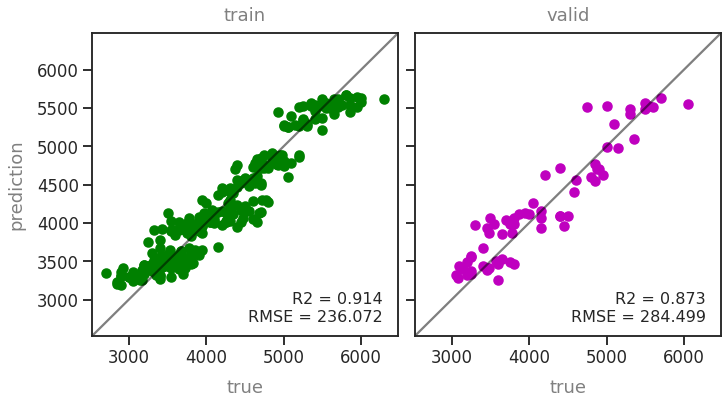

In [58]:
# 코드 작성
fig, r2_default = get_parity(y_train, y_val, y_pred_train, y_pred_val)